## Детектирование периодических колебаний с помощью автокодировщика

### Генерация новых данных

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('encoder_df.csv')

In [3]:
df = df[df['NI'] != 4].copy()
df.drop(columns=['NI', 't_start'], inplace=True)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
1,9411,9409,9440,9446,9414,9427,9430,9413,9441,9440,...,9447,9440,9427,9418,9374,9369,9355,9298,9298,9298
2,9029,9154,9181,9280,9355,9405,9408,9444,9492,9537,...,9818,9849,9782,9740,9714,9711,9652,9652,9636,9558
3,9505,9477,9421,9408,9415,9387,9307,9295,9261,9266,...,8916,8880,8854,8846,8855,8868,8874,8908,8949,8973
4,8973,8990,8991,9010,9048,9055,9154,9221,9288,9383,...,9779,9807,9787,9814,9758,9726,9712,9708,9683,9658
5,9656,9600,9562,9544,9506,9470,9443,9379,9399,9370,...,9068,9063,9011,8964,8959,8935,8907,8936,8935,8882


In [5]:
df.shape

(476, 200)

In [6]:
df[df['0']==df['0'].max()]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
273,13812,13853,13885,13912,13920,13867,13841,13815,13776,13774,...,13550,13549,13505,13527,13553,13573,13592,13603,13580,13584


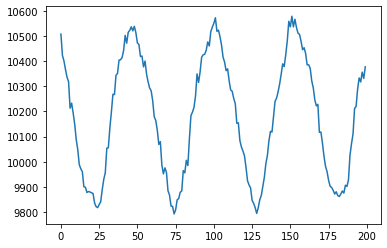

In [7]:
x = np.array(df)
plt.plot(range(x.shape[1]), x[100])

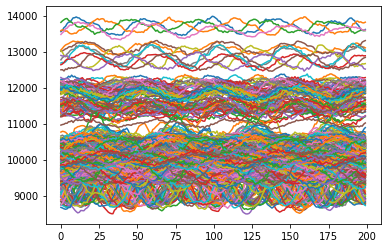

In [8]:
for i in x:
    plt.plot(range(x.shape[1]), i)

In [9]:
test = x[100]

In [10]:
noise = np.random.normal(-100,100, x.shape[1])

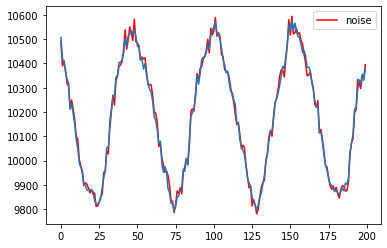

In [11]:
random_mean = np.random.uniform(-10,10)
random_std  = np.random.uniform(0,40)
noise = np.random.normal(0, random_std, 200)
plt.plot(range(test.shape[0]), test + noise, color='red', label='noise')
plt.plot(range(test.shape[0]), test)
plt.legend()

In [12]:
epochs = 20
new_x = []
for e in range(epochs):
    for i in x:
        random_mean = np.random.uniform(-10,10)
        random_std  = np.random.uniform(0,30)
        noise = np.random.normal(0, random_std, i.shape[0])
        new_x.append(i + noise)
    if (e+1) % 5 == 0:
        print("Epoch %d: %d" % (e+1, len(new_x)))

Epoch 5: 2380
Epoch 10: 4760
Epoch 15: 7140
Epoch 20: 9520


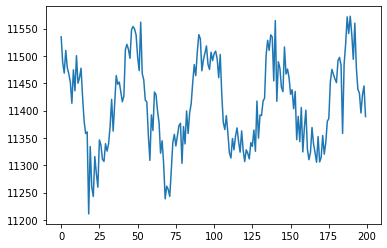

In [15]:
plt.plot(range(200), new_x[1000])

In [16]:
x.min()

8491

### Автокодировщик

In [17]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [18]:
batch_size = 128
lr = 0.001

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [20]:
x = np.array(new_x)
x.shape

(9520, 200)

In [21]:
pd.DataFrame(x).to_csv('sin_generated.csv', index=False)

In [22]:
scaler  = MinMaxScaler()

x = np.array(new_x)
#x = scaler.fit_transform(x)
x_train, x_test, _, _ = train_test_split(x, np.zeros((len(x))), random_state=42)

x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

In [23]:
x_train.round(2)

array([[0.24, 0.25, 0.25, ..., 0.04, 0.03, 0.02],
       [0.14, 0.15, 0.17, ..., 0.13, 0.14, 0.14],
       [0.05, 0.05, 0.05, ..., 0.21, 0.22, 0.22],
       ...,
       [0.06, 0.05, 0.05, ..., 0.27, 0.3 , 0.32],
       [0.65, 0.63, 0.62, ..., 0.63, 0.64, 0.64],
       [0.15, 0.15, 0.15, ..., 0.21, 0.22, 0.24]])

In [24]:
# берем только те примеры из x_train, которые не являются аномальными
train_in_distribution = x_train
train_in_distribution = torch.tensor(train_in_distribution.astype(np.float32))

train_in_dataset = TensorDataset(train_in_distribution)
train_in_loader = DataLoader(train_in_dataset, batch_size=batch_size, shuffle=True)

# для теста и валидации возьмем все примеры, чтобы можно было сравнивать работу модели на обычных и аномальных данных
test_dataset = TensorDataset(
    torch.tensor(x_test.astype(np.float32)),
    #torch.tensor(y_test.astype(np.long))
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#val_dataset = TensorDataset(torch.tensor(x_val.astype(np.float32)))
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### Глубокий автокодировщик

In [33]:
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, input_size),
            nn.LeakyReLU(0.2),
            )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [34]:
INPUT_SHAPE = 196
model = Autoencoder(INPUT_SHAPE)
criterion = nn.MSELoss()
per_sample_criterion = nn.MSELoss(reduction="none") # loss для каждого примера, пропущенного через модель
# без параметра reduction="none" pytorch усредняет loss'ы по всем объектам
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [35]:
epochs = 25

for epoch in range(epochs):
    running_loss = 0
    for (x_batch, ) in train_in_loader:
        x_batch = x_batch[:,:INPUT_SHAPE]

        output = model(x_batch)
        loss = criterion(output, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print("epoch [{}/{}], train loss:{:.4f}".format(epoch+1, epochs, running_loss))

epoch [1/25], train loss:1.8194
epoch [2/25], train loss:0.2701
epoch [3/25], train loss:0.2285
epoch [4/25], train loss:0.1219
epoch [5/25], train loss:0.0425
epoch [6/25], train loss:0.0375
epoch [7/25], train loss:0.0341
epoch [8/25], train loss:0.0306
epoch [9/25], train loss:0.0279
epoch [10/25], train loss:0.0260
epoch [11/25], train loss:0.0250
epoch [12/25], train loss:0.0229
epoch [13/25], train loss:0.0222
epoch [14/25], train loss:0.0206
epoch [15/25], train loss:0.0253
epoch [16/25], train loss:0.0199
epoch [17/25], train loss:0.0192
epoch [18/25], train loss:0.0188
epoch [19/25], train loss:0.0191
epoch [20/25], train loss:0.0207
epoch [21/25], train loss:0.0194
epoch [22/25], train loss:0.0187
epoch [23/25], train loss:0.0237
epoch [24/25], train loss:0.0178
epoch [25/25], train loss:0.0180


#### Проверка восстановления сигнала

In [36]:
# функция, которая возвращает восстановленные объекты
def get_prediction(model, x):
    global batch_size

    dataset = TensorDataset(torch.tensor(x.astype(np.float32)))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    for batch in data_loader:
        x_batch = batch[0]
        pred = model(x_batch) # x -> encoder -> decoder -> x_pred
        predictions.append(pred.detach().cpu().numpy())

    predictions = np.concatenate(predictions)
    return predictions

# визуализация объектов из нескольких выборок (реальной и восстановленной)
def compare_data(xs, sample_num, data_range=(0, 1), labels=None, inverse_transform=False):
    fig, axes = plt.subplots(len(xs))
    sample_size = len(xs[0][sample_num])

    for i in range(len(xs)):
        if inverse_transform:
            axes[i].plot(np.linspace(*data_range, sample_size), 
                         scaler.inverse_transform(xs[i][sample_num].reshape(1,x_test[:, INPUT_SHAPE]))[0])
        else:
            axes[i].plot(np.linspace(*data_range, sample_size), xs[i][sample_num])

    if labels:
        for i, label in enumerate(labels):
            axes[i].set_ylabel(label)

In [37]:
def get_difference_score(model, x):
    global batch_size

    dataset = TensorDataset(torch.tensor(x.astype(np.float32)))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    for (x_batch, ) in data_loader:
        x_batch = x_batch[:,:INPUT_SHAPE]
        preds = model(x_batch)
        predictions.append(preds.detach().cpu().numpy())

    predictions = np.concatenate(predictions)

    # вычитание предсказанных примеров из реальных
    return (x[:,:INPUT_SHAPE] - predictions.reshape(-1,INPUT_SHAPE))

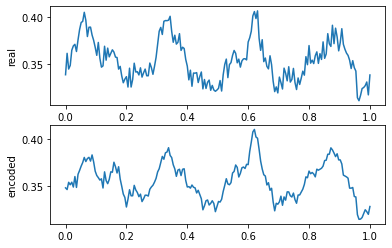

In [38]:
x_test_pred = get_prediction(model, x_test[:, :INPUT_SHAPE])
compare_data([x_test[:,:INPUT_SHAPE], x_test_pred], 10, labels=["real", "encoded"])

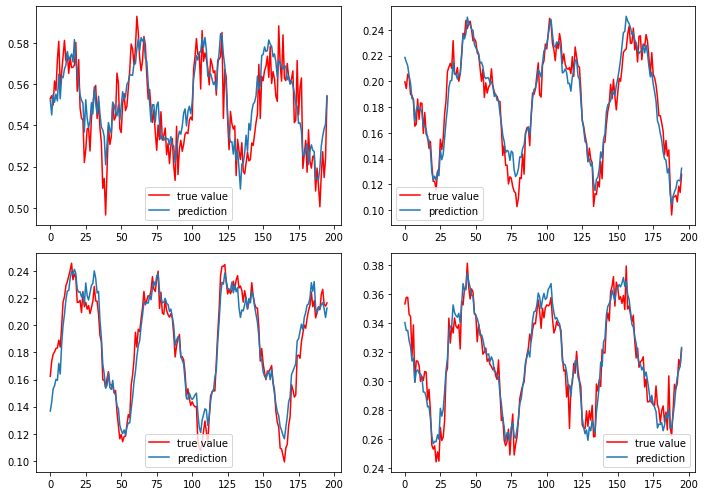

In [40]:
arr = np.random.randint(0,len(x_test), 4)
i=0
f, axs = plt.subplots(int(len(arr)/2), 2, figsize=(10, 7))
axs = axs.flatten()
for index in arr:
    asd = model(torch.tensor(x_test[index][:INPUT_SHAPE].astype(np.float32)))
    pred = asd.detach().numpy().reshape(1, asd.shape[0])
    sns.lineplot(x=range(INPUT_SHAPE), y=x_test[index][:INPUT_SHAPE].reshape(1,asd.shape[0])[0], 
                 color='r', ax=axs[i], label='true value')
    sns.lineplot(x=range(INPUT_SHAPE), y=pred[0], ax=axs[i], label='prediction')
    i+=1
    
f.tight_layout()

In [305]:
torch.save(model.state_dict(), "autoencoder_v1")

In [320]:
autoen = Autoencoder(x_train.shape[1])
autoen.load_state_dict(torch.load("autoencoder_v1"))

<All keys matched successfully>

### Свёрточный автокодировщик

In [83]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),  # b, 16, 5, 5
            nn.Conv1d(64, 32, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 64, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose1d(64, 32, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose1d(32, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [84]:
INPUT_SHAPE = 196
model = ConvAutoencoder()
criterion = nn.MSELoss()
per_sample_criterion = nn.MSELoss() # loss для каждого примера, пропущенного через модель
# без параметра reduction="none" pytorch усредняет loss'ы по всем объектам
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [85]:
epochs = 100

for epoch in range(epochs):
    running_loss = 0
    for (x_batch, ) in train_in_loader:
        x_batch = x_batch[:,np.newaxis,:INPUT_SHAPE]

        output = model(x_batch)
        loss = criterion(output, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print("epoch [{}/{}], train loss:{:.4f}".format(epoch+1, epochs, running_loss))

epoch [1/100], train loss:1.4651
epoch [2/100], train loss:0.0665
epoch [3/100], train loss:0.0296
epoch [4/100], train loss:0.0195
epoch [5/100], train loss:0.0163
epoch [6/100], train loss:0.0148
epoch [7/100], train loss:0.0139
epoch [8/100], train loss:0.0130
epoch [9/100], train loss:0.0123
epoch [10/100], train loss:0.0118
epoch [11/100], train loss:0.0117
epoch [12/100], train loss:0.0109
epoch [13/100], train loss:0.0106
epoch [14/100], train loss:0.0107
epoch [15/100], train loss:0.0100
epoch [16/100], train loss:0.0102
epoch [17/100], train loss:0.0100
epoch [18/100], train loss:0.0097
epoch [19/100], train loss:0.0094
epoch [20/100], train loss:0.0096
epoch [21/100], train loss:0.0093
epoch [22/100], train loss:0.0090
epoch [23/100], train loss:0.0093
epoch [24/100], train loss:0.0088
epoch [25/100], train loss:0.0087
epoch [26/100], train loss:0.0090
epoch [27/100], train loss:0.0086
epoch [28/100], train loss:0.0088
epoch [29/100], train loss:0.0086
epoch [30/100], train l

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
def get_difference_score(model, x):
    global batch_size

    dataset = TensorDataset(torch.tensor(x.astype(np.float32)))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    for (x_batch, ) in data_loader:
        x_batch = x_batch[:,np.newaxis,:INPUT_SHAPE]
        preds = model(x_batch)
        predictions.append(preds.detach().cpu().numpy())

    predictions = np.concatenate(predictions)

    # вычитание предсказанных примеров из реальных
    return x[:,:INPUT_SHAPE] - predictions.reshape(-1,INPUT_SHAPE)
    #return mean_squared_error(x[:,:INPUT_SHAPE], predictions.reshape(-1,INPUT_SHAPE))

#### Проверка восстановления сигнала

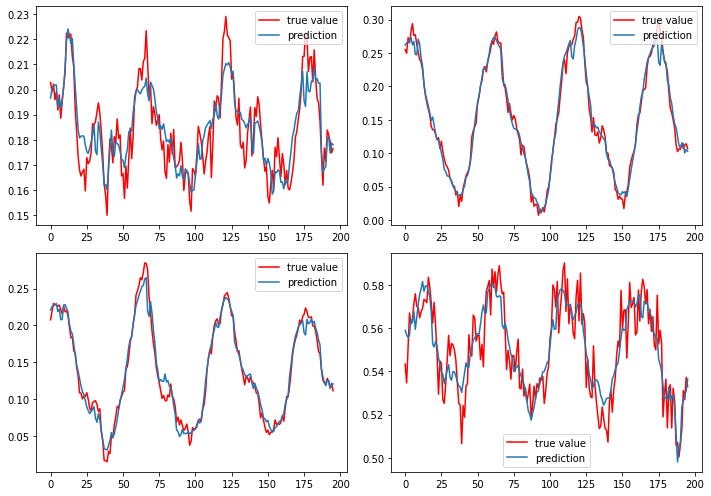

In [91]:
arr = np.random.randint(0,len(x_test), 4)
i=0
f, axs = plt.subplots(int(len(arr)/2), 2, figsize=(10, 7))
axs = axs.flatten()
for index in arr:
    x_batch = x_test[:,np.newaxis,:INPUT_SHAPE]
    asd = model(torch.tensor(x_batch[index][np.newaxis,:,:INPUT_SHAPE].astype(np.float32)))
    pred = asd.detach().numpy().reshape(1,asd.shape[2])[0]
    sns.lineplot(x=range(INPUT_SHAPE), y=x_test[index][:INPUT_SHAPE], 
                 color='r', ax=axs[i], label='true value')
    sns.lineplot(x=range(INPUT_SHAPE), y=pred, ax=axs[i], label='prediction')
    i+=1
    
f.tight_layout()

In [119]:
torch.save(model.state_dict(), "conv_autoencoder_v1")

In [320]:
conv_autoen = Autoencoder()
conv_autoen.load_state_dict(torch.load("conv_autoencoder_v1"))

<All keys matched successfully>

Свёрточный автокодировщик показал себя в работе лучше, так как ищет паттерны именно для гармонических колебаний. В дальнейшем будем использовать именно его

### Проверка

In [40]:
from sklearn.metrics import classification_report, precision_recall_curve

In [92]:
normal_df = pd.read_csv('normal_df.csv')
normal_df.dropna(inplace=True)
X_test = scaler.transform(normal_df.drop(columns=['NI', 't_start']))

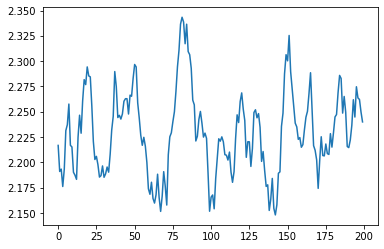

In [93]:
plt.plot(range(200), X_test[100])

In [94]:
y_test = np.zeros((len(x_test)))
Y_test = np.ones((len(X_test)))

In [95]:
Y_test.shape

(13217,)

In [96]:
X_test = np.concatenate([x_test, X_test])
y_test = np.concatenate([y_test, Y_test])

In [97]:
train_x, test_x, train_y, test_y = train_test_split(X_test, y_test, stratify=y_test, random_state=42)

In [98]:
test_score.shape

(11697, 196)

In [99]:
from sklearn.ensemble import RandomForestClassifier

test_score = get_difference_score(model, train_x)

score_forest = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
score_forest.fit(test_score, train_y)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [100]:
val_score = get_difference_score(model, test_x)
prediction = score_forest.predict(val_score)
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84       595
         1.0       0.97      0.97      0.97      3305

    accuracy                           0.95      3900
   macro avg       0.91      0.90      0.91      3900
weighted avg       0.95      0.95      0.95      3900



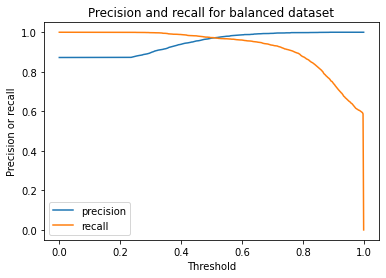

In [101]:
precision, recall, thresholds = precision_recall_curve(test_y, score_forest.predict_proba(val_score)[:,1])
thresholds = [0] + thresholds.tolist()
plt.plot(thresholds, precision, label='precision');
plt.plot(thresholds, recall, label='recall');
plt.legend(); plt.xlabel('Threshold'); plt.ylabel('Precision or recall');
plt.title('Precision and recall for balanced dataset');

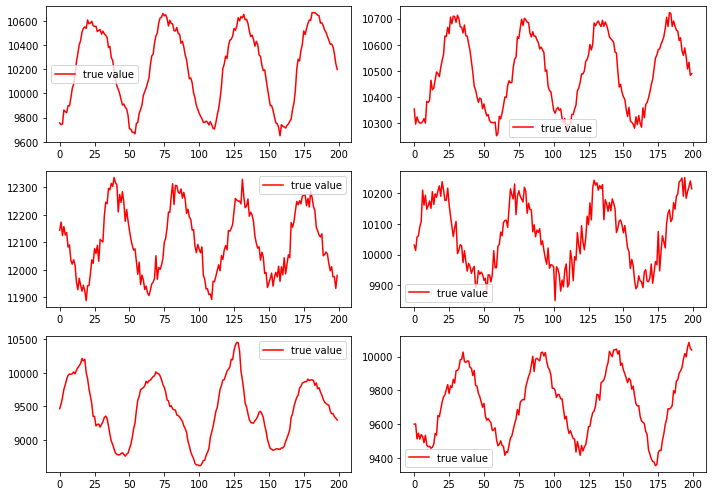

In [102]:
arr = np.random.randint(0, len(test_x[prediction==0]), 6)
i=0
f, axs = plt.subplots(int(len(arr)/2), 2, figsize=(10, 7))
axs = axs.flatten()
for index in arr:
    sns.lineplot(x=range(200), y=scaler.inverse_transform(test_x[prediction==0][index].reshape(1,200))[0], 
                 color='r', ax=axs[i], label='true value')
    i+=1
    
f.tight_layout()

### Тестирование

In [103]:
segment_df = pd.read_csv('segment_frame.csv')
segment_df = segment_df[segment_df['0'] != 0]
x = segment_df.drop(columns=['NI', 'tstart', 'tend', 'sin'])

In [104]:
x_scaled = scaler.transform(x)

In [2]:
%%script False
# для глубокого автокодировщика
arr = np.random.randint(0,len(x_scaled), 4)
i=0
f, axs = plt.subplots(int(len(arr)/2), 2, figsize=(10, 7))
axs = axs.flatten()
for index in arr:
    asd = model(torch.tensor(x_scaled[index][:INPUT_SHAPE].astype(np.float32)))
    pred = asd.detach().numpy().reshape(1, asd.shape[0])
    sns.lineplot(x=range(INPUT_SHAPE), y=x_scaled[index][:INPUT_SHAPE].reshape(1,asd.shape[0])[0], 
                 color='r', ax=axs[i], label='true value')
    sns.lineplot(x=range(INPUT_SHAPE), y=pred[0], ax=axs[i], label='prediction')
    i+=1
    
f.tight_layout()

Couldn't find program: 'False'


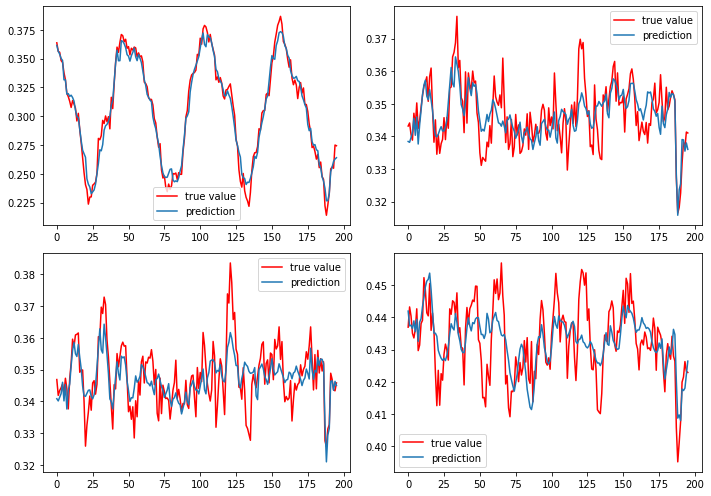

In [105]:
arr = np.random.randint(0,len(x_scaled), 4)
i=0
f, axs = plt.subplots(int(len(arr)/2), 2, figsize=(10, 7))
axs = axs.flatten()
for index in arr:
    x_batch = x_scaled[:,np.newaxis,:INPUT_SHAPE]
    asd = model(torch.tensor(x_batch[index][np.newaxis,:,:INPUT_SHAPE].astype(np.float32)))
    pred = asd.detach().numpy().reshape(1,asd.shape[2])[0]
    sns.lineplot(x=range(INPUT_SHAPE), y=x_scaled[index][:INPUT_SHAPE], 
                 color='r', ax=axs[i], label='true value')
    sns.lineplot(x=range(INPUT_SHAPE), y=pred, ax=axs[i], label='prediction')
    i+=1
    
f.tight_layout()

In [106]:
testing_score = get_difference_score(model, x_scaled)
prediction = score_forest.predict(testing_score)
#prediction = score_forest.predict(x_scaled[:, :INPUT_SHAPE])

In [107]:
testing_score.shape

(5524, 196)

In [108]:
pd.value_counts(prediction)

1.0    5390
0.0     134
dtype: int64

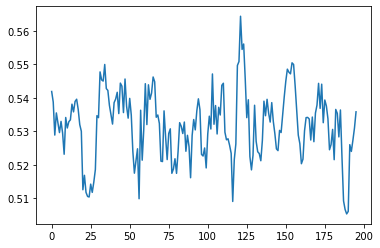

In [109]:
plt.plot(range(INPUT_SHAPE), x_scaled[1000,:INPUT_SHAPE])

In [110]:
true_preds = x_scaled[prediction == 0]

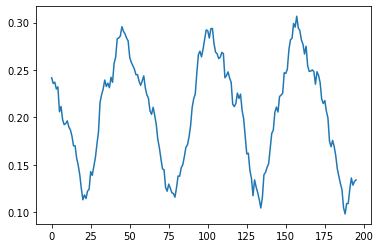

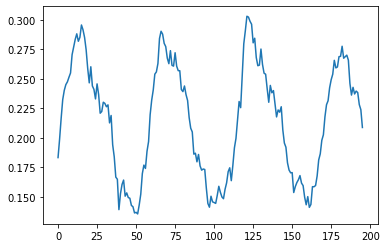

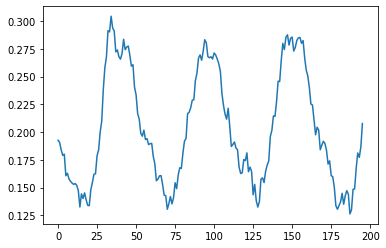

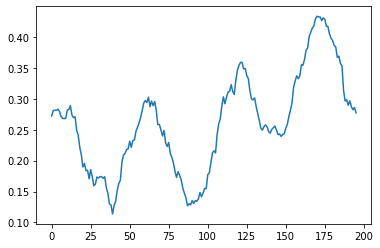

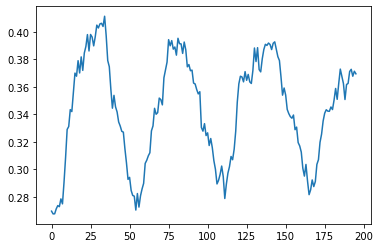

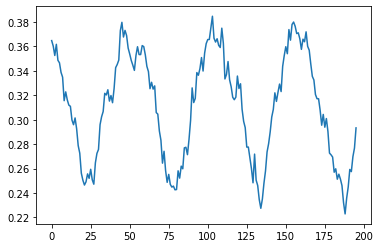

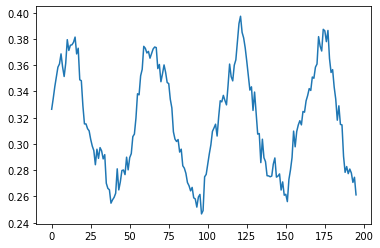

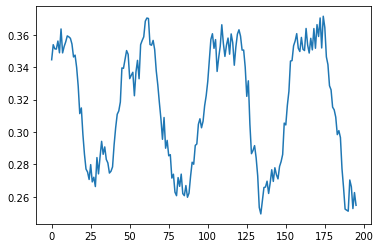

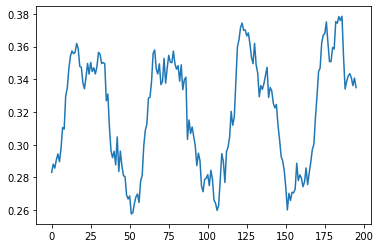

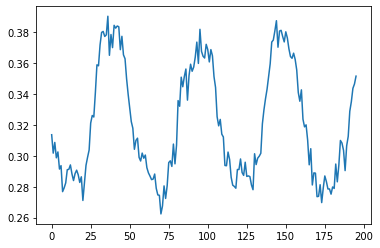

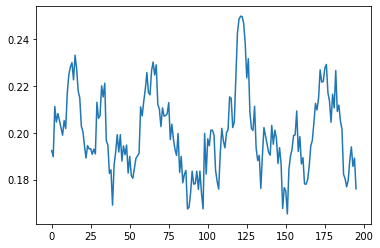

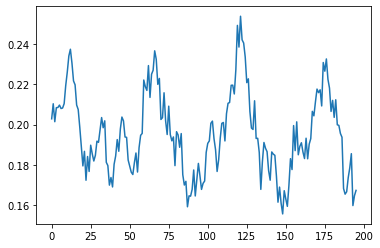

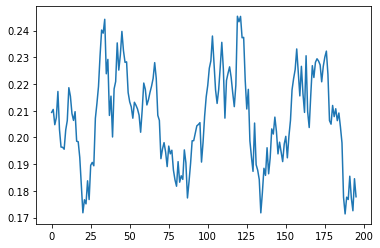

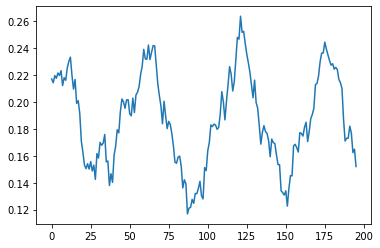

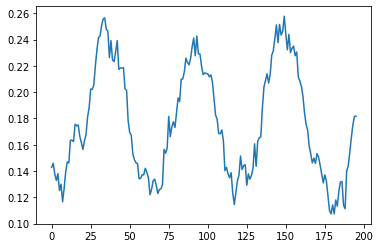

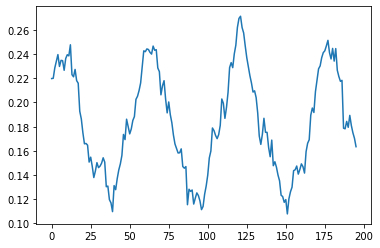

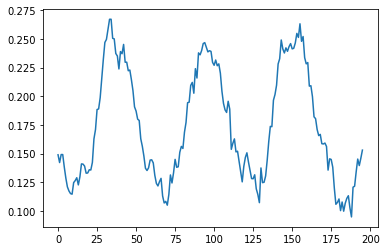

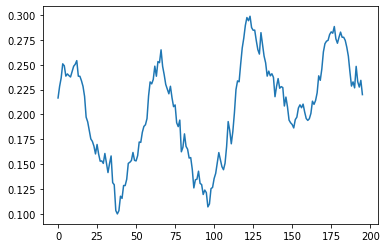

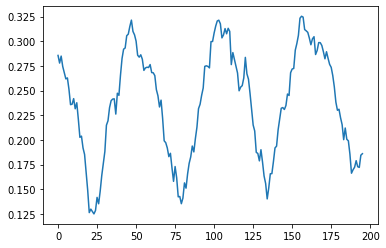

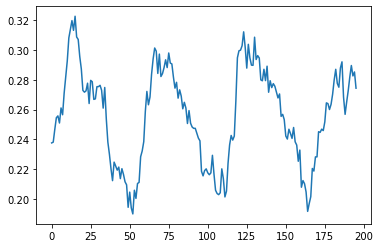

In [121]:
for i in range(110,130):
    plt.figure()
    plt.plot(range(INPUT_SHAPE), true_preds[i,:INPUT_SHAPE])

### Сохраним результаты

In [122]:
import os
experiment_path = "true_pred_pics" # папка для сохранения картинок
#!rm -rf $experiment_path
os.makedirs(experiment_path, exist_ok=True)

In [123]:
cnt = 0
for i in range(len(true_preds)):
    cnt += 1
    
    x_batch = true_preds[i,np.newaxis,:INPUT_SHAPE]
    asd = model(torch.tensor(x_batch[np.newaxis,:,:INPUT_SHAPE].astype(np.float32)))
    pred = asd.detach().numpy().reshape(1,asd.shape[2])[0]
    
    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.plot(range(INPUT_SHAPE), true_preds[i, :INPUT_SHAPE], color='blue', label='true')
    ax.plot(range(INPUT_SHAPE), pred, color='red', label='pred')
    ax.legend()
    plt.savefig(os.path.join(experiment_path, 
             "{}.jpg".format(cnt)))
    plt.close(fig)

In [124]:
prediction.shape

(5524,)

In [125]:
segment_df['sin'] = prediction

In [126]:
segment_df.to_csv('segment_frame.csv', index=False)